<a href="https://colab.research.google.com/github/TrSaleMane/deep-learning-from-step-by-step/blob/main/vol08_pytorch_mnist/vol08_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vol.8：PyTorchでMNISTモデルを作る

このノートブックでは、PyTorch を使って MNIST の分類モデル（MLP）を実装します。

 ライブラリの読み込み

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

モデル定義（nn.Module）

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)  # 入力 → 隠れ層
        self.fc2 = nn.Linear(128, 10)   # 隠れ層 → 出力

    def forward(self, x):
        x = x.view(-1, 784)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # logits

データの読み込み

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.90MB/s]


学習ループ

In [ ]:
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

loss_list = []

for epoch in range(5):
    for x, y in train_loader:
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0414
Epoch 2, Loss: 0.2360
Epoch 3, Loss: 0.0931
Epoch 4, Loss: 0.0068
Epoch 5, Loss: 0.0539


精度の確認

In [ ]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for x, y in test_loader:
        out = model(x)
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

print("Accuracy:", correct / total)

Accuracy: 0.9785


学習曲線の可視化

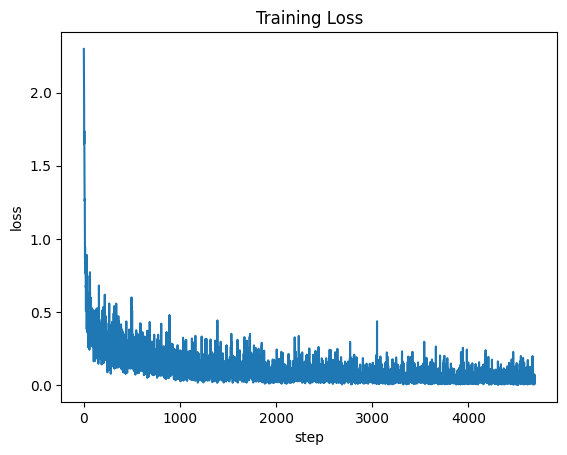

In [ ]:
plt.plot(loss_list)
plt.title("Training Loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

##✨ 実践編：自分の手書き数字を判定してみよう

画像アップロード


任意のファイル名で、Google Colabにアップロードしてみてください。

1.   ローカルPCで、bmp、jpg、pngなど画像ファイルを新規作成します。
2.   手書きで数字を描いて、保存します。
3.   下記のコードを実行して、Google Colabにアップロードしてください。
4.   Google Colabのルートフォルダに手書き画像ファイルが保存されます。

※注意　MNISTのデータに合わせて、背景色：黒、文字の色：白で画像データを作ってください。

In [ ]:
from google.colab import files
uploaded = files.upload()

画像の読み込み

Google Colabのルートフォルダに保存された画像ファイルをを読み込みます。

※ここでは、最初にアップロードされたファイル名を取得しています。

新規 ビットマップ イメージ.png


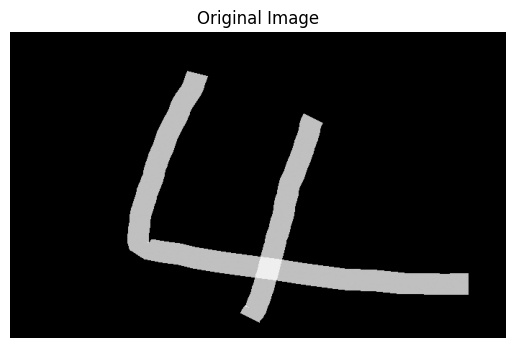

In [ ]:
from PIL import Image

filename = list(uploaded.keys())[0]
img = Image.open(filename)
print(filename)

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

グレースケール化

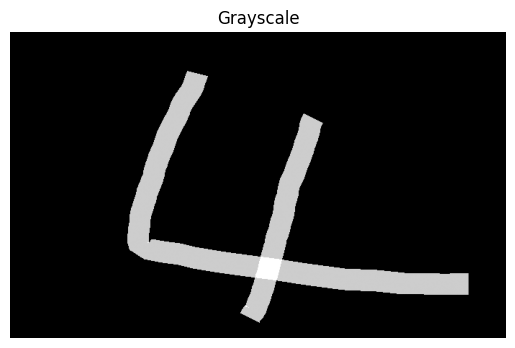

In [ ]:
img = img.convert("L")
plt.imshow(img, cmap="gray")
plt.title("Grayscale")
plt.axis("off")
plt.show()

28×28 にリサイズ

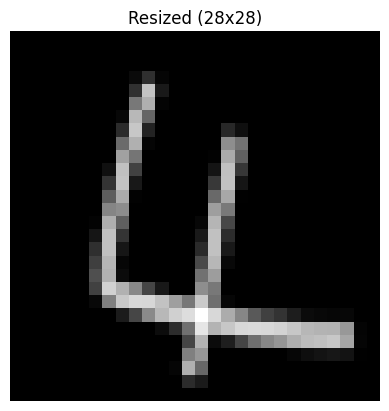

In [ ]:
img = img.resize((28, 28))
plt.imshow(img, cmap="gray")
plt.title("Resized (28x28)")
plt.axis("off")
plt.show()

MNIST と同じ正規化

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

img_tensor = transform(img)
img_tensor = img_tensor.view(1, 1, 28, 28)
print(img_tensor.shape)

torch.Size([1, 1, 28, 28])


モデルに入力して予測

In [ ]:
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred = output.argmax(dim=1).item()

print("予測された数字：", pred)

予測された数字： 5


 結果を表示

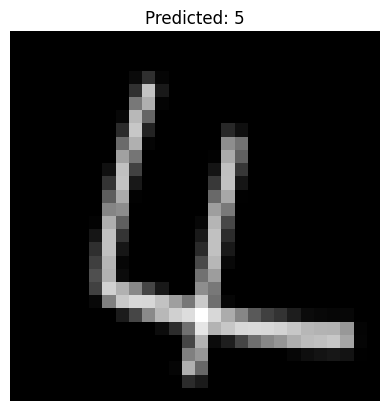

In [ ]:
plt.imshow(img, cmap="gray")
plt.title(f"Predicted: {pred}")
plt.axis("off")
plt.show()



---



##認識精度に関する注意点

ひょっとすると手書き認識の精度が思ったほどよくないかもしれません。

これは、手書きの画像ファイルのデータとMNISTの画像データと、条件（背景色、文字色、文字位置など）をちゃんと合わせないと、いくらAccuracyが90%以上であっても（あくまでもMNISTのテストとフィットしている学習モデル）手書きのデータでは認識がうまくいかないからです。

特に、特にMLP（全結合）だと：

- 位置のズレに弱い
- 太さや傾きに弱い
- ノイズに弱い

といったことが考えられます。

じゃあどうすれば？？というところですが、ひとつは「MINISTに合わせた手書きのデータを作る」ですが、もうひとつは「CNNモデル（畳み込み）に切り替える」です。

CNN（畳み込み）なら
- 位置ズレ
- 太さ
- 回転

に強くなります。

次のシリーズでは、CNN（畳み込みニューラルネット）を取り上げる予定です。

---

## ▶ 次のステップ：Vol.9 へ進もう！

ここまでで、PyTorch を使った MNIST モデルの

- モデル定義（nn.Module）
- 学習ループ
- 精度評価
- 手書き数字の推論

まで体験できました。

次の **Vol.9** では、  
**「精度を上げるための工夫」** を学びます。

- 学習率の調整
- 層を深くする
- ドロップアウト
- バッチサイズの工夫
- データ拡張（Augmentation）

など、実務でも使う改善テクニックを紹介します。